#Gender Disparity Visualization Tool
Analyzing the Gender Pay Gap using Open Source data from a Glassdoor survey.

See [this](https://www.kaggle.com/datasets/nilimajauhari/glassdoor-analyze-gender-pay-gap) Kaggle page for access to data.

## Environment Setup

In [171]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [172]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from shap import TreeExplainer
from shap import summary_plot
import shap
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

Plotting Stylesheet

In [173]:
colors1 = ["Violet", "Orchid", "RebeccaPurple", "Purple", "MediumVioletRed"]
colors2 = ["LightGreen", "LawnGreen", "LimeGreen", "Green", "Olive"]
colors = ["LightGreen", "Violet", "LawnGreen", "Orchid", "LimeGreen", "RebeccaPurple", "Green", "Purple", "Olive", "MediumVioletRed"]

## Data Exploration

In [174]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/aditijc/Gender_Disparity_Visualization_Tool/main/Glassdoor_Gender_Pay_Gap.csv', 'Gender_Pay_Gap.csv')
df = pd.read_csv("Gender_Pay_Gap.csv")
df

,JobTitle,Gender,Age,PerfEval,Education,Dept,Seniority,BasePay,Bonus
0,Graphic Designer,Female,18,5,College,Operations,2,42363,9938
1,Software Engineer,Male,21,5,College,Management,5,108476,11128
2,Warehouse Associate,Female,19,4,PhD,Administration,5,90208,9268
3,Software Engineer,Male,20,5,Masters,Sales,4,108080,10154
4,Graphic Designer,Male,26,5,Masters,Engineering,5,99464,9319
...,...,...,...,...,...,...,...,...,...
995,Marketing Associate,Female,61,1,High School,Administration,1,62644,3270
996,Data Scientist,Male,57,1,Masters,Sales,2,108977,3567
997,Financial Analyst,Male,48,1,High School,Operations,1,92347,2724
998,Financial Analyst,Male,65,2,High School,Administration,1,97376,2225


In [175]:
df.describe()

,Age,PerfEval,Seniority,BasePay,Bonus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.393000,3.037000,2.971000,94472.653000,6467.161000
std,14.294856,1.423959,1.395029,25337.493272,2004.377365
min,18.000000,1.000000,1.000000,34208.000000,1703.000000
25%,29.000000,2.000000,2.000000,76850.250000,4849.500000
50%,41.000000,3.000000,3.000000,93327.500000,6507.000000
75%,54.250000,4.000000,4.000000,111558.000000,8026.000000
max,65.000000,5.000000,5.000000,179726.000000,11293.000000


In [176]:
corr_df = df.corr()
cor= corr_df.corr(method='pearson')
print(cor)

                Age  PerfEval  Seniority   BasePay     Bonus
Age        1.000000 -0.721146  -0.196526  0.726010 -0.926308
PerfEval  -0.721146  1.000000  -0.514122 -0.908278  0.928369
Seniority -0.196526 -0.514122   1.000000  0.439767 -0.176154
BasePay    0.726010 -0.908278   0.439767  1.000000 -0.874863
Bonus     -0.926308  0.928369  -0.176154 -0.874863  1.000000


Plotting a Heatmap of Pearson Correlation Coefficients across all features

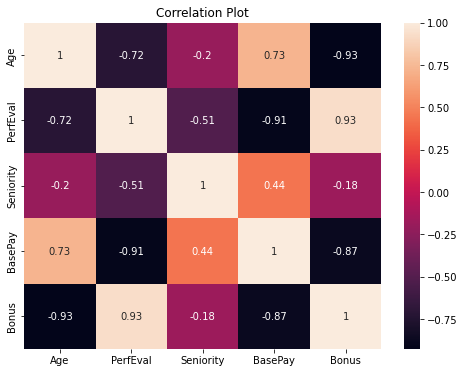

In [177]:
ig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, annot = True)
plt.show()

## Data Preprocessing

Grouping the job categories based on Technical and Non-Technical Jobs

In [178]:
def job_categories(job_title):
  technical_jobs = ['Software Engineer','IT', 'Financial Analyst','Data Scientist']
  non_tech_jobs = ['Graphic Designer','Warehouse Associate','Sales Associate', 'Driver', 'Marketing Associate','Manager']
  if job_title in technical_jobs:
    return 'Technical'
  elif job_title in non_tech_jobs:
    return 'Non-technical'

df['JobCategory'] = df['JobTitle'].apply(job_categories)
del df['JobTitle']

Separating Numerical and Categorical Data

In [179]:
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])
num_at = list(numeric_data)
categorical_d= list(categorical_data)

print(f'Shape of numeric data: {numeric_data.shape[1]}')
print(f'Shape of categorical data: {categorical_data.shape[1]}')

Shape of numeric data: 5
Shape of categorical data: 4


In [180]:
edu_map = {"High School":0, "College":1, "Masters": 2, "PhD":3}
df["Education"] = df["Education"].replace(edu_map)

# Label Encoding Education
categorical_d.remove("Education")
num_at.append("Education")

# Dropping Gender as Independent Variable
df_drop_gender = pd.DataFrame(df.drop(columns=['Gender']))
categorical_d.remove("Gender")

# One-hot Encoding
one_hot_cols = ['JobCategory', 'Gender', 'Dept']
labeled_df = pd.get_dummies(df, columns = one_hot_cols)

# Preprocessing Pipeline
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_at),
        ("cat", OneHotEncoder(), categorical_d),
    ])

# Independent variable input to K-means
X_transformed = full_pipeline.fit_transform(df_drop_gender)

## Examining Feature Contributions to Model Predictions
We examined the contributions of a set of features to a Random Forest Classifier's predictions of Base Income. We found that gender was a significant feature in making this prediction. 

In [181]:
adjusted_df = labeled_df.dropna()
bins = [34000, 90000, 180000]
labels = ['Low income','High income']
adjusted_df['BasePay'] = pd.cut(adjusted_df['BasePay'], bins = bins, labels=labels)
adjusted_df["BasePay"]=adjusted_df.BasePay.replace(to_replace=['Low income','High income'], value=[0, 1])

X_train = adjusted_df.drop(columns=['BasePay'])
feature_labels = X_train.keys()
X_train = num_pipeline.fit_transform(X_train)

y_train = adjusted_df['BasePay']

In [182]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=10, scoring = 'f1')

rf.fit(X_train, y_train)
tree_explainer = TreeExplainer(rf)
shap_values = np.array(tree_explainer.shap_values(X_train))

print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))

RF train accuracy: 1.000


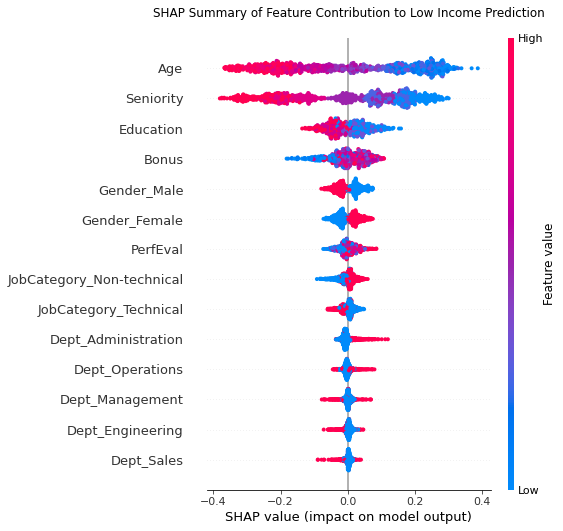

In [183]:
summary_plot(shap_values[0], X_train, feature_names = feature_labels, show=False)
plt.title('SHAP Summary of Feature Contribution to Low Income Prediction\n')
plt.show()

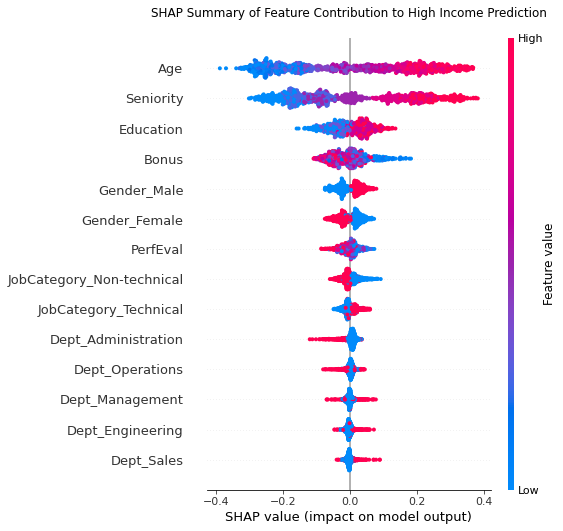

In [184]:
summary_plot(shap_values[1], X_train, feature_names = feature_labels, show=False)
plt.title('SHAP Summary of Feature Contribution to High Income Prediction\n')
plt.show()

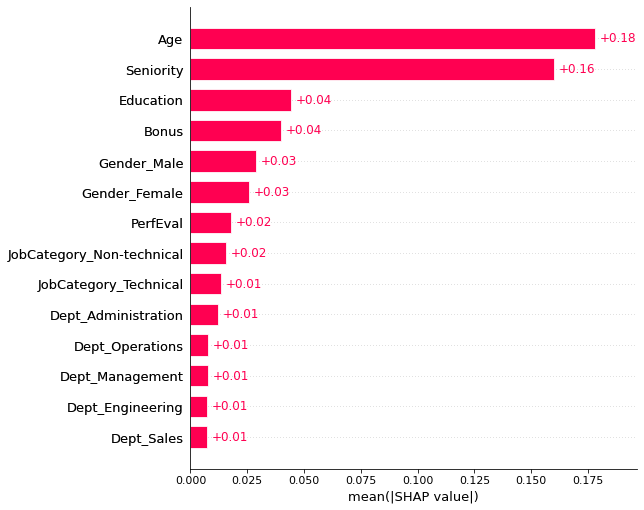

In [185]:
X_train = pd.DataFrame(X_train, columns = feature_labels)
shap_values = tree_explainer(X_train)
shap_values.base_values = shap_values.base_values[1]
shap_values.values = shap_values.values[:,:,0]
shap.plots.bar(shap_values, max_display=25, show=False)

## Clustering

### Hyperparameter Tuning
Finding the optimal number of clusters

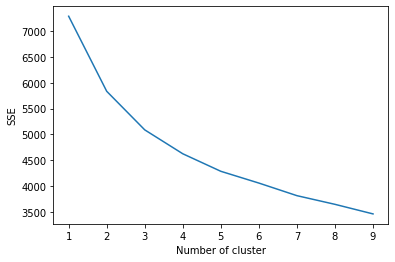

In [186]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init="random", n_init=5, max_iter=500, random_state=1).fit(X_transformed)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Clustering with Final Hyperparameters

In [187]:
kmeans = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=300, random_state=1)
y_pred = kmeans.fit_predict(X_transformed)
centers_list = kmeans.cluster_centers_

### Statistics on Clustered Data
We calculated statistics for each cluster, including mean, std values, etc. for the numerical input features provided in the dataset, and percentages for the categorical input features.

In [188]:
mean_arr = []
std_arr = []
max_arr = []
min_arr = []
median_arr = []

In [189]:
numerical_data_visual = []
categorical_data_visual = []

In [190]:
for ind in range(len(centers_list )): 
  index_list = np.where(y_pred == ind)
  ind_list = np.asarray(index_list)[0]
  cluster_groups = df.iloc[ind_list]

  cluster_means = cluster_groups.mean(axis=0, numeric_only=True)
  cluster_std_devs = cluster_groups.std(axis=0, numeric_only=True)
  cluster_median = cluster_groups.median(axis=0, numeric_only=True)
  cluster_min = cluster_groups.min(axis=0, numeric_only=True)
  cluster_max = cluster_groups.max(axis=0, numeric_only=True)

  mean_arr.append(cluster_means)
  std_arr.append(cluster_std_devs)
  min_arr.append(cluster_min)
  max_arr.append(cluster_max)
  median_arr.append(cluster_median)
  
  print("Cluster Number " + str(ind))
  numerical_stats = { 'Mean': cluster_means, 'Standard Deviation': cluster_std_devs, 'Median': cluster_median, 'Min Val': cluster_min, 'Max Val': cluster_max }
  numerical_stats_pd = pd.DataFrame(numerical_stats)
  print(numerical_stats_pd)
  numerical_data_visual.append(numerical_stats_pd)

Cluster Number 0
                    Mean  Standard Deviation    Median  Min Val  Max Val
Age            47.109827           12.117380      48.0       18       65
PerfEval        1.826590            0.780570       2.0        1        3
Education       1.803468            1.054663       2.0        0        3
Seniority       4.358382            0.738400       5.0        2        5
BasePay    118810.219653        16749.872289  116069.0    77839   179726
Bonus        5151.849711         1114.014645    5120.0     2661     7721
Cluster Number 1
                   Mean  Standard Deviation   Median  Min Val  Max Val
Age           53.144928            8.144225     55.0       31       65
PerfEval       2.091787            0.998193      2.0        1        5
Education      1.405797            1.148898      1.0        0        3
Seniority      1.893720            0.799459      2.0        1        4
BasePay    96146.207729        17030.071742  95995.0    53839   136836
Bonus       4312.739130      

In [191]:
for ind in range(len(centers_list )): 
  index_list = np.where(y_pred == ind)
  ind_list = np.asarray(index_list)[0]
  cluster_groups = df.iloc[ind_list]


  gender_arr = cluster_groups["Gender"].value_counts()
  gender_arr = gender_arr.rename_axis('Gender').reset_index(name='Gender_Percentage')
  gender_arr["Gender_Percentage"] /=  len(cluster_groups)

  dept_arr = cluster_groups["Dept"].value_counts()
  dept_arr = dept_arr.rename_axis('Dept').reset_index(name="Dept_Percentage")
  dept_arr["Dept_Percentage"] /=  len(cluster_groups)

  job_cat_arr = cluster_groups["JobCategory"].value_counts()
  job_cat_arr = job_cat_arr.rename_axis('JobCategory').reset_index(name="Job_Category_Percentage")
  job_cat_arr["Job_Category_Percentage"] /=  len(cluster_groups)


  print("Cluster Number " + str(ind))
  print(" ")
  print(gender_arr)
  print(" ")
  print(dept_arr)
  print(" ")
  print(job_cat_arr)
  print(" ")
  print(" ")

  categorical_data_visual.append(pd.concat([gender_arr, dept_arr, job_cat_arr], axis = 1))


Cluster Number 0
 
   Gender  Gender_Percentage
0    Male           0.537572
1  Female           0.462428
 
             Dept  Dept_Percentage
0     Engineering         0.231214
1      Management         0.225434
2  Administration         0.196532
3      Operations         0.179191
4           Sales         0.167630
 
     JobCategory  Job_Category_Percentage
0  Non-technical                 0.647399
1      Technical                 0.352601
 
 
Cluster Number 1
 
   Gender  Gender_Percentage
0    Male           0.507246
1  Female           0.492754
 
             Dept  Dept_Percentage
0           Sales         0.251208
1      Operations         0.222222
2  Administration         0.198068
3      Management         0.173913
4     Engineering         0.154589
 
     JobCategory  Job_Category_Percentage
0  Non-technical                 0.565217
1      Technical                 0.434783
 
 
Cluster Number 2
 
   Gender  Gender_Percentage
0    Male           0.518919
1  Female           0.4

### Visualizing Disparities

Plotting Methods

In [192]:
# Categorical Feature: gender, Numerical Feature: mean/average or median
def categorical_vs_numerical_gender(numerical_feat_calc, num_feature, cat_feat, gender):
  '''
  Method to plot categorical input features with respect to numerical features 
  of data set, looking at the categorical features' correlation to base pay or 
  bonus pay.
  '''
  x_vals = []
  y_vals = []
  e_ = 1
  color_var = 'magenta'
  color_arr = colors1
  if gender == 'Male':
    e_ = 0
    color_var = 'green'
    color_arr = colors2
  for ind in range(len(centers_list)):
    # print(categorical_data_visual[ind][1])
    female_num = categorical_data_visual[ind].loc[e_][cat_feat]
    base_pay_ave = numerical_data_visual[ind][numerical_feat_calc][num_feature]
    x_vals.append(female_num)
    y_vals.append(base_pay_ave)
    plt.scatter(female_num, base_pay_ave, alpha=1, color = color_arr[ind])
    plt.xlabel("Percentage of " + str(gender) + " Samples")
    plt.ylabel(num_feature)

  fit = np.polyfit(x_vals, y_vals, 1)
  p = np.poly1d(fit)
  plt.plot(x_vals, p(x_vals), alpha = 0.75, color = color_var)

def plot_visuals(input, output):
  '''
  Method to plot 2-Variable Cluster Combinations
  '''
  for ind in range(len(centers_list)):
    index_list = np.where(y_pred == ind)
    ind_list = np.asarray(index_list)[0]
    # print(ind_list)
    # print(" ")
    cluster_groups = labeled_df.iloc[ind_list]
    women = cluster_groups.loc[cluster_groups['Gender_Female'] == 1]
    men = cluster_groups.loc[cluster_groups['Gender_Male'] == 1]
    # print(women)
    label_man = "Cluster Number for Men "+ str(ind)
    label_woman = "Cluster Number for Women "+ str(ind)
    plt.scatter(men[input], men[output], alpha=0.5, label=(label_man), color=colors[ind * 2])
    plt.scatter(women[input], women[output], alpha=0.5, label=(label_woman), color=colors[(ind * 2)+1])
    plt.xlabel(input)
    plt.ylabel(output)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True)

def plot_categorical_visuals(input, output):
  for ind in range(len(centers_list)):
    index_list = np.where(y_pred == ind)
    ind_list = np.asarray(index_list)[0]
    # print(ind_list)
    # print(" ")
    cluster_groups = df.iloc[ind_list]
    women = cluster_groups.loc[cluster_groups['Gender'] == 'Female']
    men = cluster_groups.loc[cluster_groups['Gender'] == 'Male']
    # print(women)
    label_man = "Cluster Number for Men "+ str(ind)
    label_woman = "Cluster Number for Women "+ str(ind)
    plt.scatter(men[input], men[output], alpha=0.75, label=(label_man), color=colors[ind * 2])
    plt.scatter(women[input], women[output], alpha=0.75, label=(label_woman), color=colors[(ind * 2) + 1])
    plt.xlabel(input)
    plt.ylabel(output)
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True)

def plot_hull(u_labels, pca_df, label, color):
  for i in u_labels:
    points = pca_df[label == i]
    # get convex hull
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    plt.fill(x_hull, y_hull, alpha=0.35, color = color, edgecolor = 'k')

In [193]:
female_indices = df.index[df['Gender'] == 'Female'].tolist()
male_indices = df.index[df['Gender'] == 'Male'].tolist()

#Load Data
pca = PCA(2)
 
#Transform the data
pca_df = pca.fit_transform(X_transformed)
Fpca_df = pca_df[female_indices]
Mpca_df = pca_df[male_indices]
 
kmeans = KMeans(n_clusters= 5)
 
Flabel = kmeans.fit_predict(Fpca_df)
Mlabel = kmeans.fit_predict(Mpca_df)
label = kmeans.fit_predict(pca_df)

u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

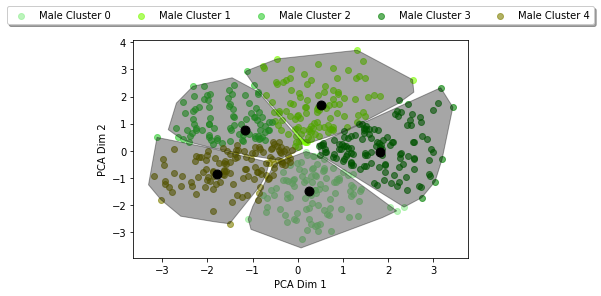

In [194]:
for i in u_labels:
    plt.scatter(Mpca_df[Mlabel == i , 0] , Mpca_df[Mlabel == i , 1] , label = f'Male Cluster {i}', alpha=0.6, color = colors2[i])
plot_hull(u_labels, pca_df, label, 'k')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.show()

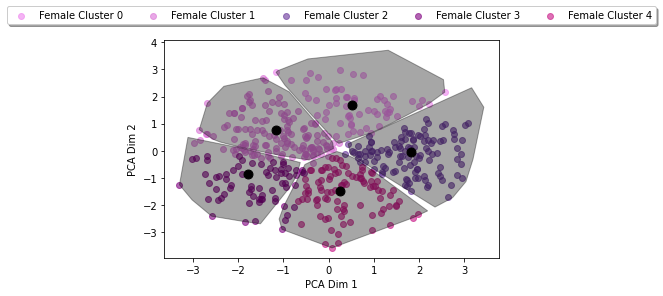

In [195]:
for i in u_labels:
    plt.scatter(Fpca_df[Flabel == i , 0] , Fpca_df[Flabel == i , 1] , label = f'Female Cluster {i}', alpha=0.6, color = colors1[i])
plot_hull(u_labels, pca_df, label, 'k')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=5, fancybox=True, shadow=True)
plt.xlabel('PCA Dim 1')
plt.ylabel('PCA Dim 2')
plt.show()

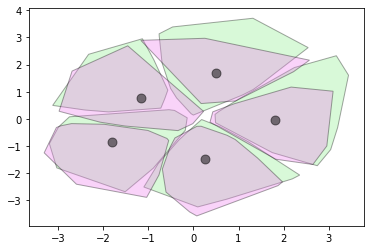

In [196]:
c1 = 'Violet'
c2 = 'LightGreen'
plot_hull(u_labels, Mpca_df, Mlabel, c2)
plot_hull(u_labels, Fpca_df, Flabel, c1)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.5, color = 'k')
plt.show()

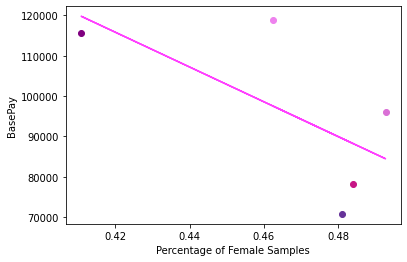

In [197]:
categorical_vs_numerical_gender('Mean', 'BasePay', 'Gender_Percentage', 'Female')

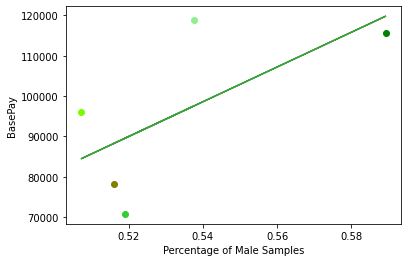

In [198]:
categorical_vs_numerical_gender('Mean', 'BasePay', 'Gender_Percentage', 'Male')

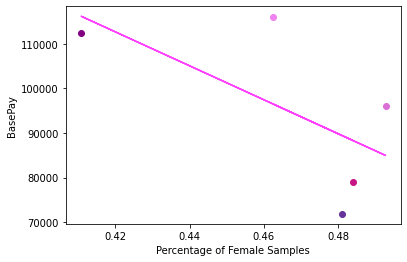

In [199]:
categorical_vs_numerical_gender('Median', 'BasePay', 'Gender_Percentage', 'Female')

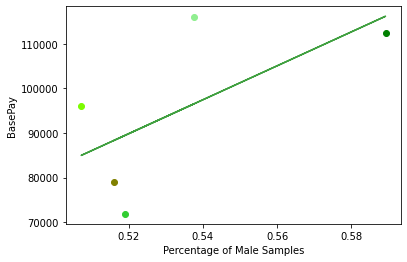

In [200]:
categorical_vs_numerical_gender('Median', 'BasePay', 'Gender_Percentage', 'Male')

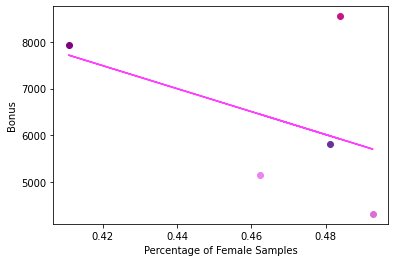

In [201]:
categorical_vs_numerical_gender('Mean', 'Bonus', 'Gender_Percentage', 'Female')

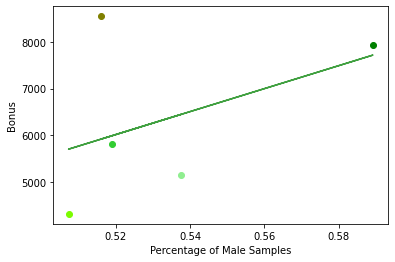

In [202]:
categorical_vs_numerical_gender('Mean', 'Bonus', 'Gender_Percentage', 'Male')

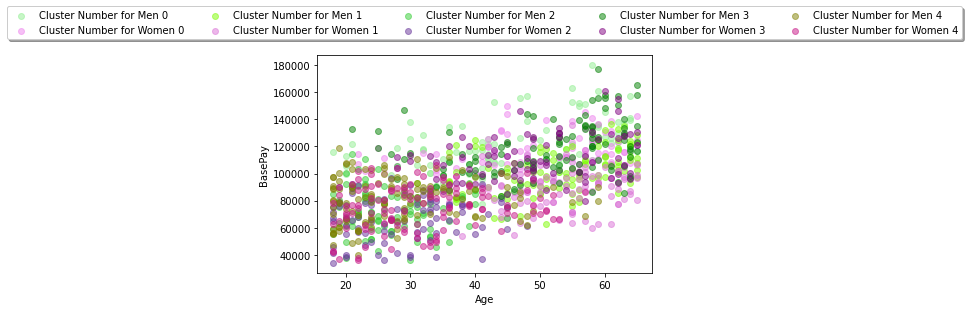

In [203]:
plot_visuals('Age', 'BasePay')

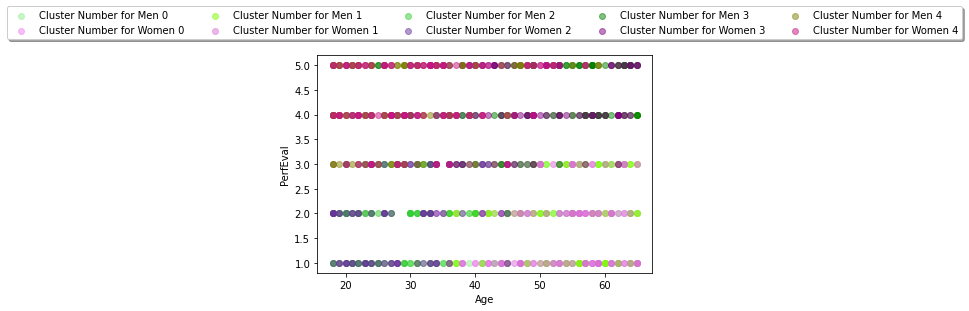

In [204]:
plot_visuals('Age', 'PerfEval')

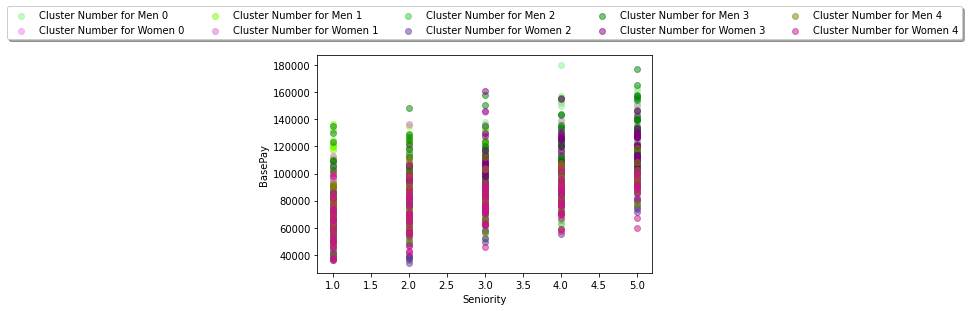

In [205]:
plot_visuals('Seniority', 'BasePay')

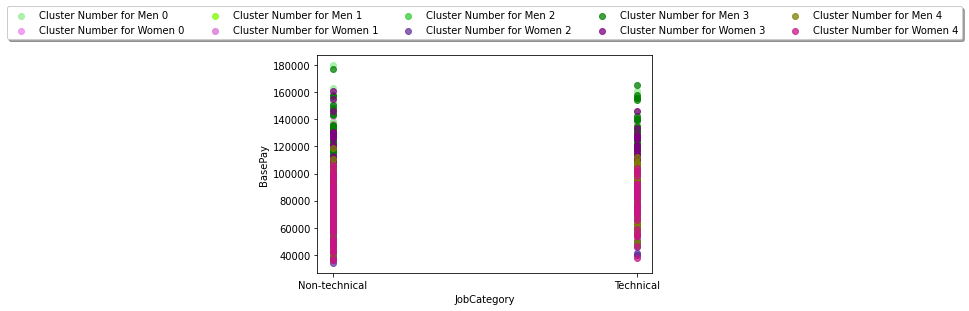

In [206]:
plot_categorical_visuals('JobCategory', 'BasePay')

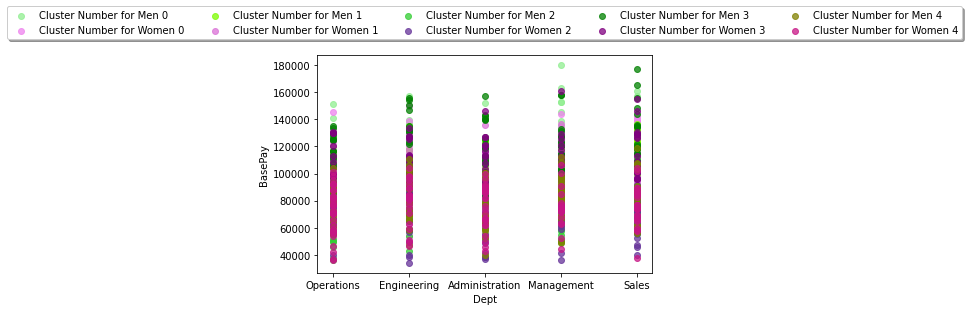

In [207]:
plot_categorical_visuals('Dept', 'BasePay')

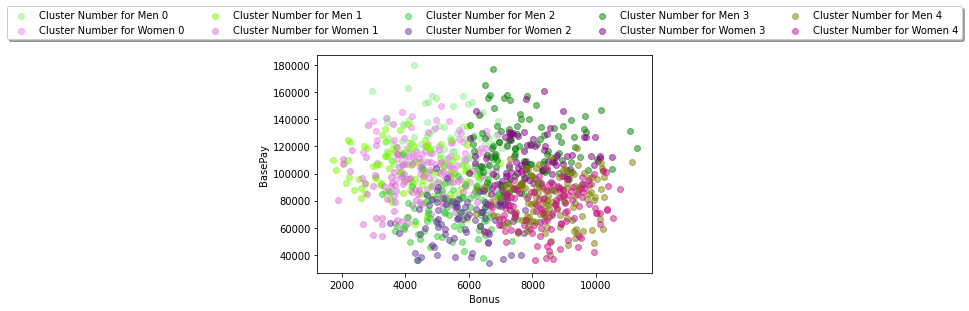

In [208]:
plot_visuals('Bonus', 'BasePay')

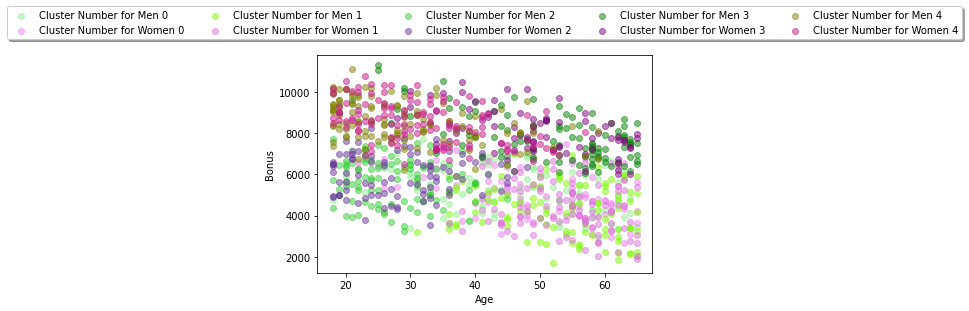

In [209]:
plot_visuals('Age', 'Bonus')